In [1]:
import os
import warnings
import time

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve
from astropy import units as u 

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures, angular_to_pixel
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments
from lcbg.photometry import flux_to_abmag
from lcbg.cosmology import cosmo_aperture_diameter

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Determine a Good Cutout Coord for Noise Estimate

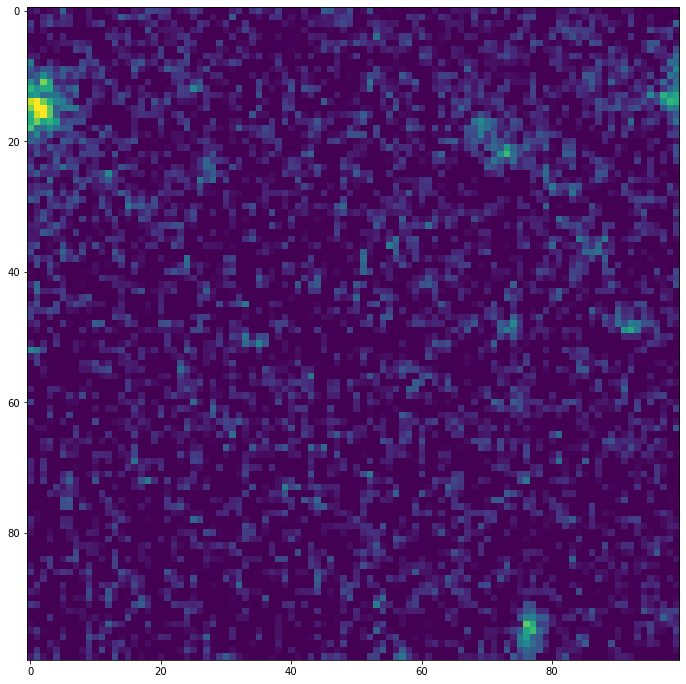

In [7]:
input_data_path = input_data_formatter.format('f105w')

hdul = fits.open(input_data_path)
hdu = hdul[0]

data = hdu.data
header = hdu.header
wcs = WCS(header)

subsection = cutout(data, 2779, 3390,  100)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)


# Do Aperture Photomerty

In [35]:
for current_filter in  filter_list:
    print(current_filter)
    
    # Load data and vitals
    # ---------------------
    
    input_data_path = input_data_formatter.format(current_filter)
    output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

    hdul = fits.open(input_data_path)
    hdu = hdul[0]

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    
    # Cutout Image
    # ------------
    
    # Estimate data noise
    subsection = cutout(data, 2779, 3390,  150)
    mean_noise = subsection.mean()
    
    # Select and crop image:
    cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
    image = cutout(data, cx, cy, 500)
    
    image_wcs = wcs.copy()
    delta_pix = np.array([cx, cy]) - np.array(image.shape)//2
    image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix
    
    image -= mean_noise
    image = np.clip(image, 0, image.max())
    

    # Catalog
    # -------
    
    #nsigma = np.zeros_like(image) + image.mean() / 3
    nsigma = np.unique(detect_threshold(image, nsigma=3.))[0]
    segm = make_segments(image, nsigma=nsigma, kernel_size=None)
    
    segm_deblend = deblend_segments(image, segm)
    #plot_segments(segm_deblend, image)

    cat = source_properties(image, segm_deblend, wcs=image_wcs)
    
        
    # Photomerty
    # ----------
    
    r_list = np.logspace(np.log10(0.06),np.log10(14), 10) * u.arcsec # approximate isophotal extent
    r_list = angular_to_pixel(r_list, wcs=wcs) # convert to pixels
    #r_list = np.unique(np.round(r_list).astype(int)) # convert to int 
    
    annulus_inner = 2
    annulus_outter = 3
    
    single_aperture_photometry_table = cat.to_table()
    for i, r in enumerate(r_list):
        print("{:0.2f}% : r={}".format(100*i/len(r_list), r))
        aperture_photometry_results = []
        for obj in cat:
            position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))

            a = obj.semimajor_axis_sigma.value * r
            b = obj.semiminor_axis_sigma.value * r
            theta = obj.orientation.to(u.rad).value

            aperture = EllipticalAperture(position, a, b, theta=theta)
            annulus = EllipticalAnnulus(position, 
                                        a*annulus_inner, 
                                        a*annulus_outter, 
                                        b*annulus_outter, 
                                        theta=theta)

            photometric_sum = aperture.do_photometry(image)[0][0] 
            #photometric_bkg = aperture.area * (annulus.do_photometry(image)[0][0] / annulus.area)

            mask = annulus.to_mask(method='center')
            annulus_data = mask.multiply(image)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
            photometric_bkg = median_sigclip * aperture.area

            photometric_value = photometric_sum - photometric_bkg

            aperture_photometry_results.append(photometric_value)
        aperture_photometry_results = np.array(aperture_photometry_results)
        
    
        # Make and save final catalog
        # ---------------------------
        single_aperture_photometry_table['aperture_sum_{}'.format(r)] =  aperture_photometry_results
        single_aperture_photometry_table['ab_mag_{}'.format(r)] = flux_to_abmag(np.array(aperture_photometry_results), header)
    
    single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
    plt.show()
    break

f105w
0.00% : r=1.0000001853939153
2.00% : r=1.117702281310471
4.00% : r=1.2492581580417699
6.00% : r=1.3962984343237694
8.00% : r=1.5606456560997073
10.00% : r=1.7443368867504745
12.00% : r=1.9496489562419563
14.00% : r=2.179126682149385
16.00% : r=2.4356144123547936
18.00% : r=2.7222912803853756
20.00% : r=3.0427106103783035
22.00% : r=3.4008439600916285
24.00% : r=3.801130347868911
26.00% : r=4.248531273719699
28.00% : r=4.748592216495285
30.00% : r=5.307511369409612
32.00% : r=5.932216465873548
34.00% : r=6.630450647889199
36.00% : r=7.4108684413323305
38.00% : r=8.283143027724602
40.00% : r=9.258086142115872
42.00% : r=10.34778208319593
44.00% : r=11.56573749667435
46.00% : r=12.927048788474789
48.00% : r=14.448589242809499
50.00% : r=16.149218164439322
52.00% : r=18.05001463741144
54.00% : r=20.174538797685425
56.00% : r=22.549123858089242
58.00% : r=25.20320250521833
60.00% : r=28.16967171392657
62.00% : r=31.48530050123963
64.00% : r=35.19118567374955
66.00% : r=39.333261217422

In [36]:
r_list

array([  1.00000019,   1.11770228,   1.24925816,   1.39629843,
         1.56064566,   1.74433689,   1.94964896,   2.17912668,
         2.43561441,   2.72229128,   3.04271061,   3.40084396,
         3.80113035,   4.24853127,   4.74859222,   5.30751137,
         5.93221647,   6.63045065,   7.41086844,   8.28314303,
         9.25808614,  10.34778208,  11.5657375 ,  12.92704879,
        14.44858924,  16.14921816,  18.05001464,  20.1745388 ,
        22.54912386,  25.20320251,  28.16967171,  31.4853005 ,
        35.19118567,  39.33326122,  43.96286764,  49.13738835,
        54.92096087,  61.38527188,  68.6104457 ,  76.68603746,
        85.71214312,  95.80064015, 107.07657419, 119.67970906,
       133.76625904, 149.51082518, 167.1085594 , 186.77758344,
       208.7616924 , 233.33337659])

In [37]:
cat = Table.read("./hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz_catalog.csv")

In [82]:
cat.sort(keys="source_sum")
cat

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_1.0000001853939153,ab_mag_1.0000001853939153,aperture_sum_1.117702281310471,ab_mag_1.117702281310471,aperture_sum_1.2492581580417699,ab_mag_1.2492581580417699,aperture_sum_1.3962984343237694,ab_mag_1.3962984343237694,aperture_sum_1.5606456560997073,ab_mag_1.5606456560997073,aperture_sum_1.7443368867504745,ab_mag_1.7443368867504745,aperture_sum_1.9496489562419563,ab_mag_1.9496489562419563,aperture_sum_2.179126682149385,ab_mag_2.179126682149385,aperture_sum_2.4356144123547936,ab_mag_2.4356144123547936,aperture_sum_2.7222912803853756,ab_mag_2.7222912803853756,aperture_sum_3.0427106103783035,ab_mag_3.0427106103783035,aperture_sum_3.4008439600916285,ab_mag_3.4008439600916285,aperture_sum_3.801130347868911,ab_mag_3.801130347868911,aperture_sum_4.248531273719699,ab_mag_4.248531273719699,aperture_sum_4.748592216495285,ab_mag_4.748592216495285,aperture_sum_5.307511369409612,ab_mag_5.307511369409612,aperture_sum_5.932216465873548,ab_mag_5.932216465873548,aperture_sum_6.630450647889199,ab_mag_6.630450647889199,aperture_sum_7.4108684413323305,ab_mag_7.4108684413323305,aperture_sum_8.283143027724602,ab_mag_8.283143027724602,aperture_sum_9.258086142115872,ab_mag_9.258086142115872,aperture_sum_10.34778208319593,ab_mag_10.34778208319593,aperture_sum_11.56573749667435,ab_mag_11.56573749667435,aperture_sum_12.927048788474789,ab_mag_12.927048788474789,aperture_sum_14.448589242809499,ab_mag_14.448589242809499,aperture_sum_16.149218164439322,ab_mag_16.149218164439322,aperture_sum_18.05001463741144,ab_mag_18.05001463741144,aperture_sum_20.174538797685425,ab_mag_20.174538797685425,aperture_sum_22.549123858089242,ab_mag_22.549123858089242,aperture_sum_25.20320250521833,ab_mag_25.20320250521833,aperture_sum_28.16967171392657,ab_mag_28.16967171392657,aperture_sum_31.48530050123963,ab_mag_31.48530050123963,aperture_sum_35.19118567374955,ab_mag_35.19118567374955,aperture_sum_39.333261217422944,ab_mag_39.333261217422944,aperture_sum_43.96286764364613,ab_mag_43.96286764364613,aperture_sum_49.13738834848075,ab_mag_49.13738834848075,aperture_sum_54.92096087272352,ab_mag_54.92096087272352,aperture_sum_61.385271878750295,ab_mag_61.385271878750295,aperture_sum_68.61044569778353,ab_mag_68.61044569778353,aperture_sum_76.68603746101611,ab_mag_76.68603746101611,aperture_sum_85.71214312432814,ab_mag_85.71214312432814,aperture_sum_95.80064014521538,ab_mag_95.80064014521538,aperture_sum_107.0765741899654,ab_mag_107.0765741899654,aperture_sum_119.67970905914436,ab_mag_119.67970905914436,aperture_sum_133.7662590425286,ab_mag_133.7662590425286,aperture_sum_149.51082517580437,ab_mag_149.51082517580437,aperture_sum_167.1085593986974,ab_mag_167.1085593986974,aperture_sum_186.7775834390029,ab_mag_186.7775834390029,aperture_sum_208.7616924042829,ab_mag_208.7616924042829,aperture_sum_233.33337659191355,ab_mag_233.33337659191355
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [72]:
mag_col_names = [i for i in cat.colnames if "aperture_sum_" in i]

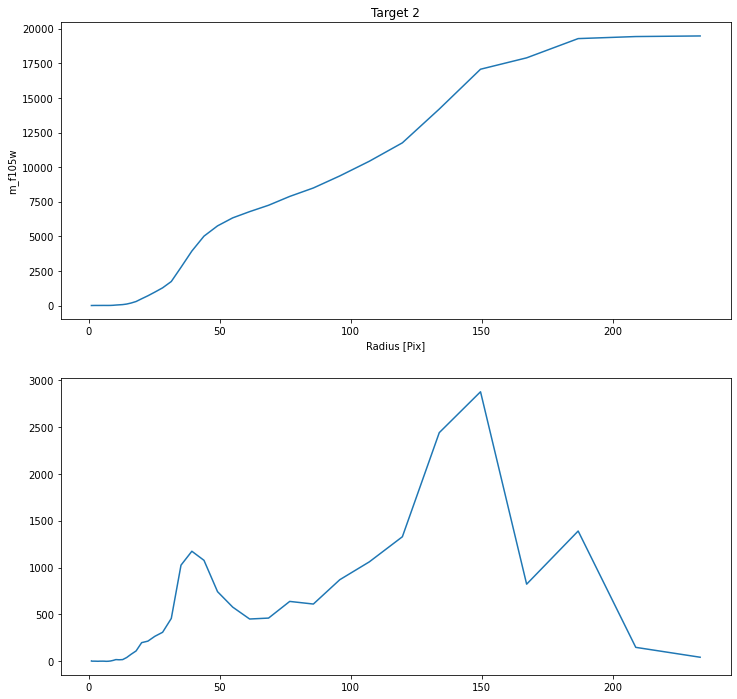

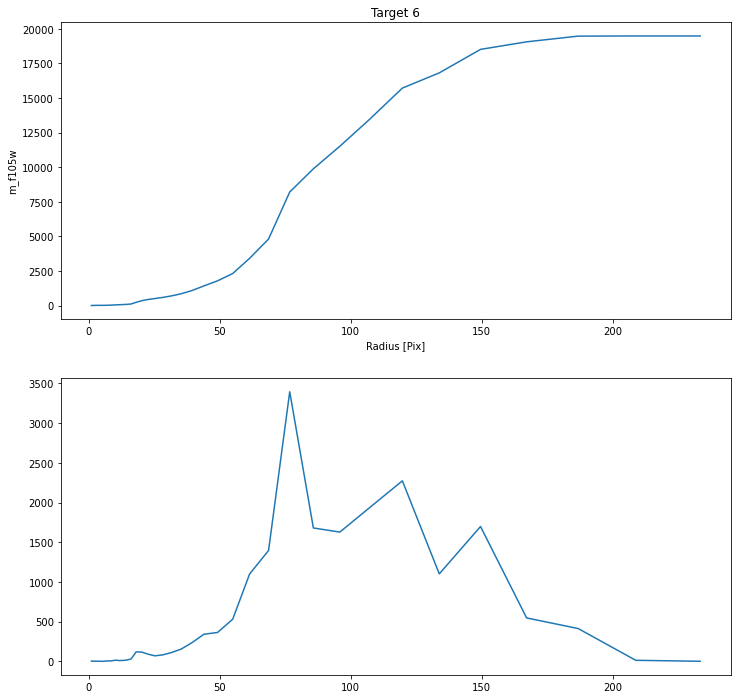

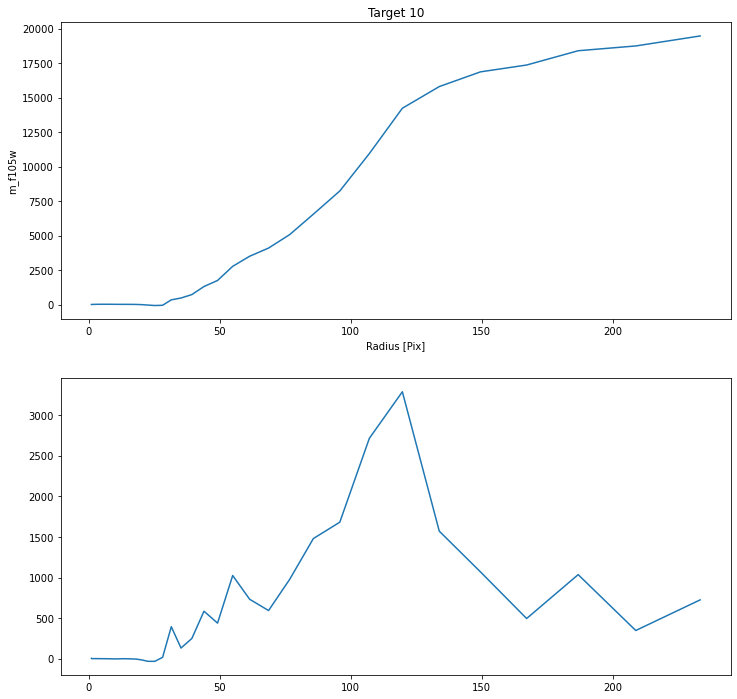

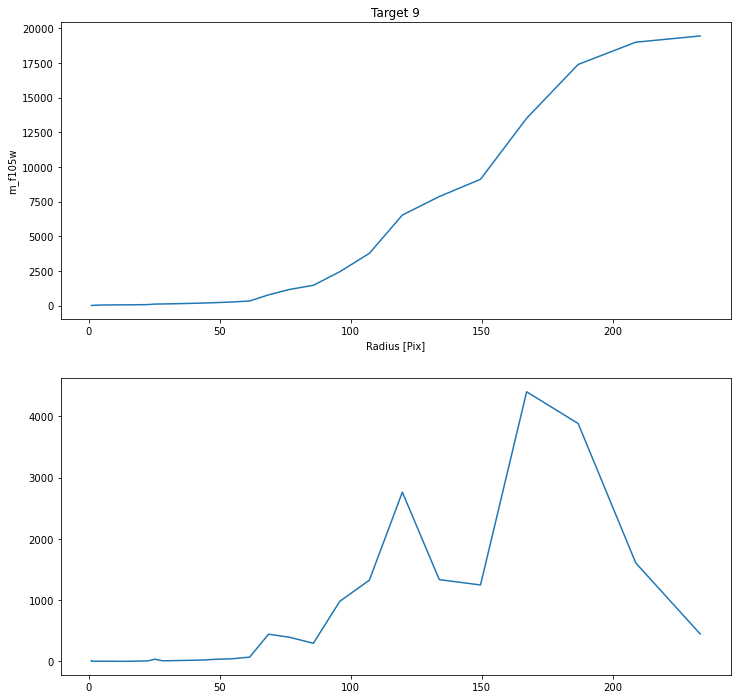

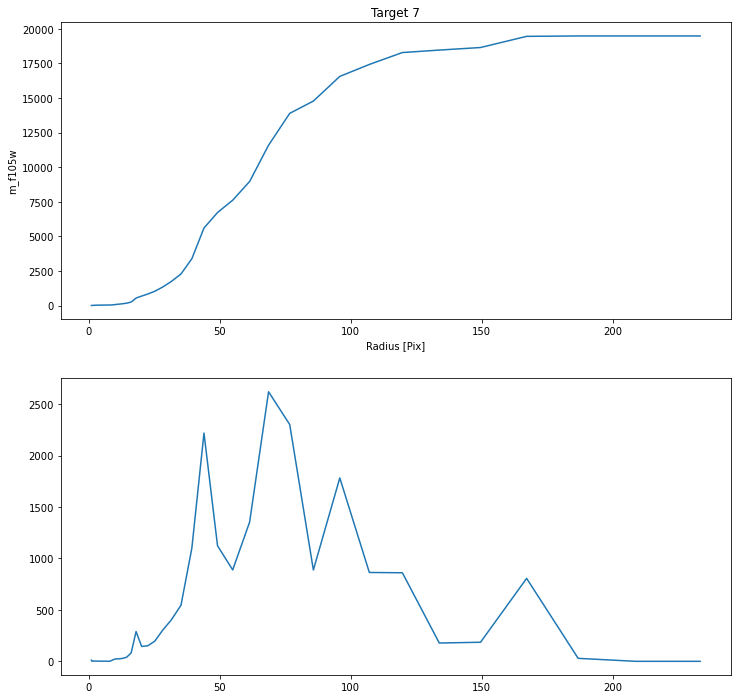

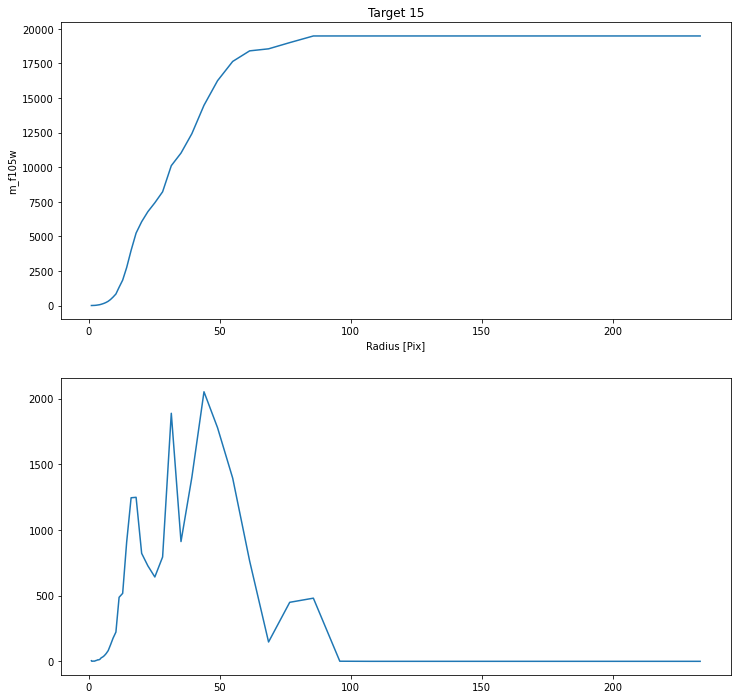

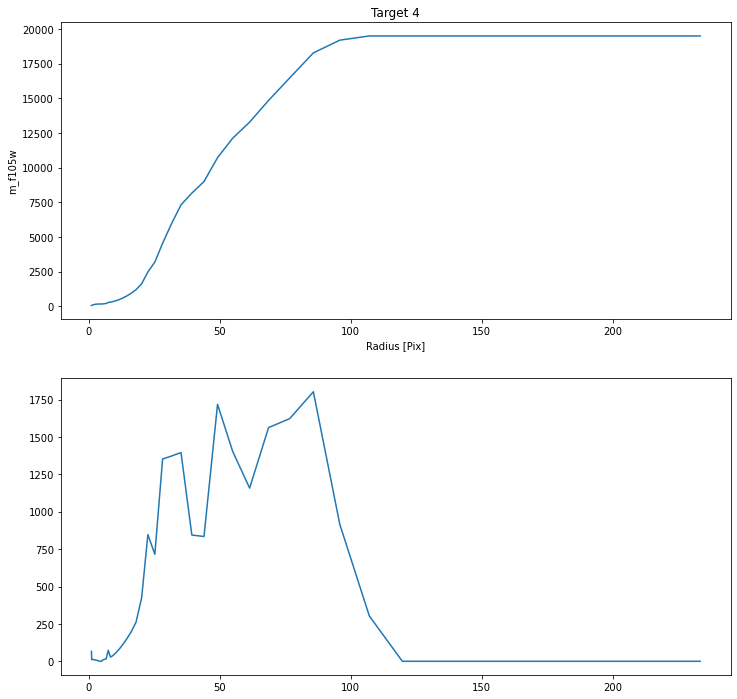

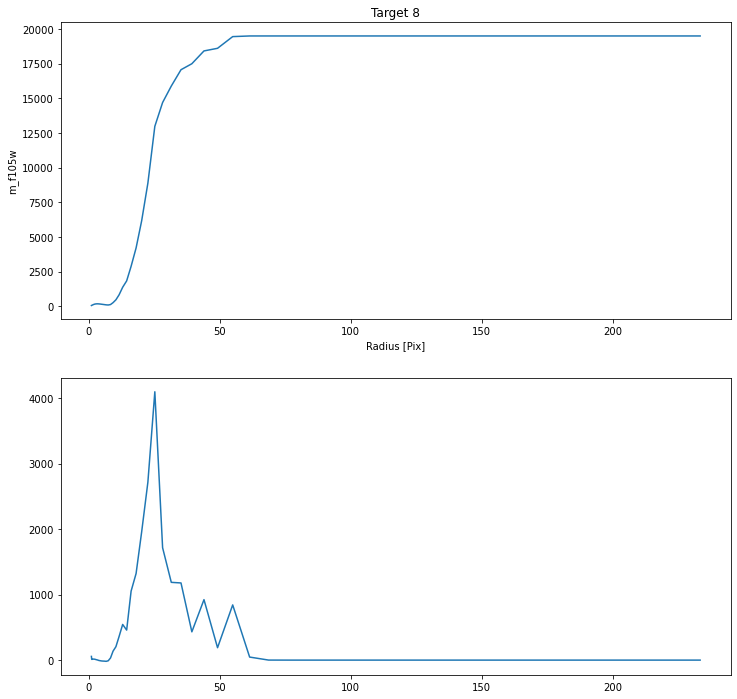

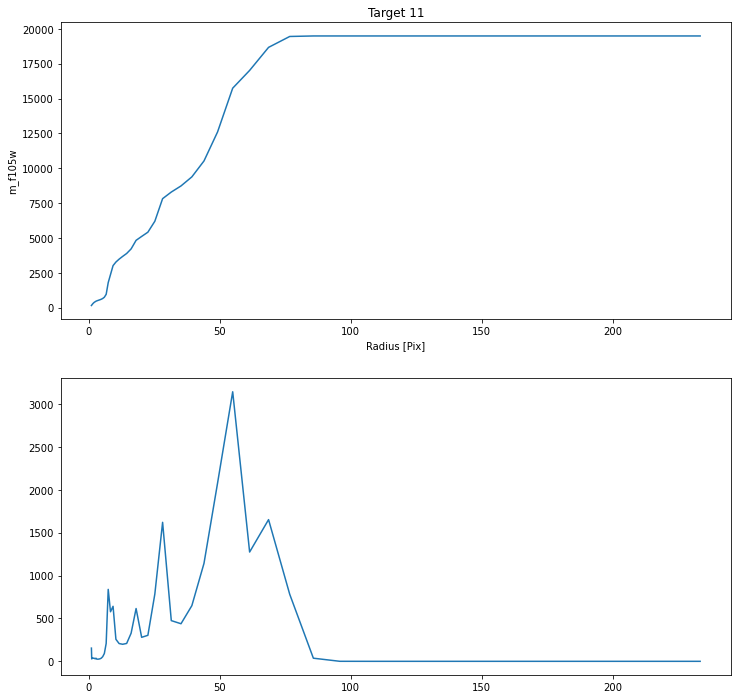

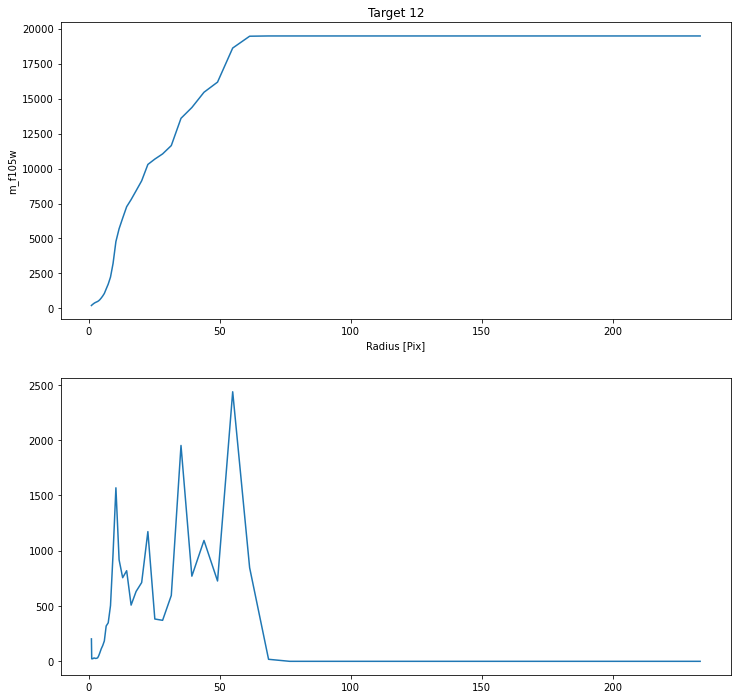

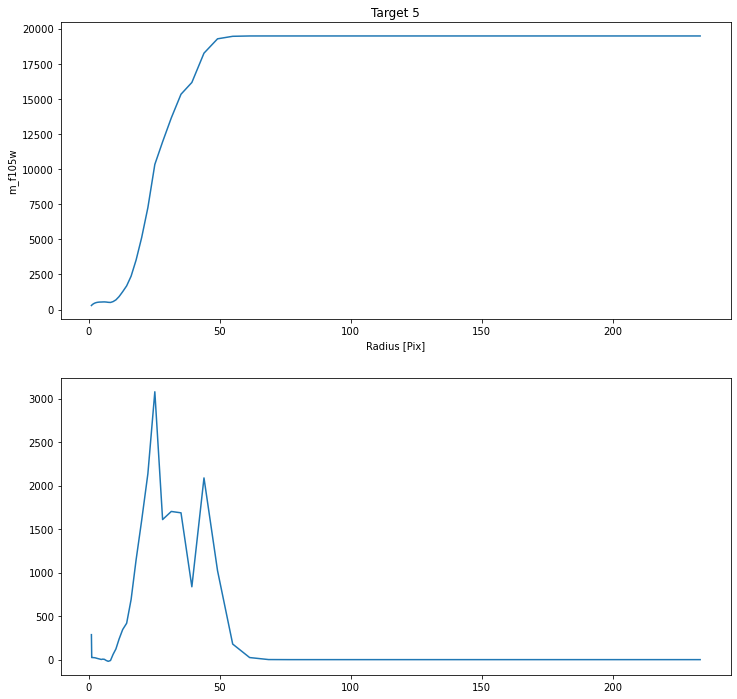

In [86]:
for idx, row in enumerate(cat):
    mags = list(row[mag_col_names])
    
    f, ax = plt.subplots(2, 1)
    
    ax[0].plot(r_list, mags)
    ax[0].set_title("Target "+str(row['id']))
    ax[0].set_xlabel("Radius [Pix]")
    ax[0].set_ylabel("m_f105w")
    
    y_values = []
    for i in range(len(mags)):
        if i == 0:
            y_values.append(mags[i])
            continue
        y_values.append(mags[i] - mags[i-1])    
    ax[1].plot(r_list, y_values, label="Raw")
    plt.show()
    if idx == 10:
        break
    print("\n"*2)

In [ ]:
def slider(x):
    cutout_size = radii[-1]*4
    
    
    target = cutout(image_smoothed, 
                    int(round(phot_table[x][1].value)), 
                    int(round(phot_table[x][2].value)),
                    cutout_size)
    
    target_bkg = phot_table[x][phot_table.colnames[-1]]/annulus_area
    
    
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(target, vmin=vmin, vmax=vmax)
    ax[0,0].set_title("Target".format(vmax))
    
    ax[0,1].imshow(np.clip(target-target_bkg, 0, target.max()), vmin=vmin, vmax=vmax)
    ax[0,1].set_title("Target [CircularAnnulus Subtracted]")
    
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    for r in radii:
        CircularAperture(position, r=r).plot(ax[0,0], color='w')
        CircularAperture(position, r=r).plot(ax[0,1], color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,0], color='r')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,1], color='r')
    
    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = [phot_table["aperture_sum_{}".format(i)][x] for i in range(len(radii))]
    ax[1,0].plot(radii, y_values, label="Raw")
    
    y_values = [phot_table["aperture_sum_{}_bkgsub".format(i)][x] for i in range(len(radii))]
    ax[1,0].plot(radii, y_values, linestyle='--', label="Bkg Subtracted")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = []
    phot_values = [phot_table["aperture_sum_{}".format(i)][x] for i in range(len(radii))]
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, label="Raw") 
    
    y_values = []
    phot_values = [phot_table["aperture_sum_{}_bkgsub".format(i)][x] for i in range(len(radii))]
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, linestyle='--', label="Bkg Subtracted") 
    
    ax[1,1].set_title("Photometic Density")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Sum")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    cutout_size = radii[-1] * 2
    target = cutout(image_smoothed, 
                    int(round(phot_table[x][1].value)), 
                    int(round(phot_table[x][2].value)),
                    cutout_size)
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    
    plt.imshow(target)
    for r in radii:
        CircularAperture(position, r=r).plot(plt.gca(), color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(plt.gca(), color='r')


    plt.show()

vmin = 0
vmax = mean_noise*0.5
#widgets.interact_manual(slider, x=widgets.IntSlider(min=0, max=len(phot_table)-1));
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(phot_table)-1));

In [ ]:
#plot_segments(segm_deblend, image, vmax=image.mean()*6)

In [14]:
from astropy.wcs.utils import proj_plane_pixel_scales

In [17]:
angular_diameter = 14*u.arcsec
pixel_scales = proj_plane_pixel_scales(wcs)
assert np.allclose(*pixel_scales)
pixel_scale = pixel_scales[0] * wcs.wcs.cunit[0] / u.pix

pixel_size = angular_diameter / pixel_scale.to(angular_diameter.unit / u.pix)
pixel_size = pixel_size.value
pixel_size


233.33337659191358

In [18]:
angular_to_pixel(angular_diameter, wcs)

233.33337659191358

In [22]:
r_list =# * u.arcsec 
r_list

array([ 0.06      ,  0.06706212,  0.07495548,  0.08377789,  0.09363872,
        0.10466019,  0.11697892,  0.13074758,  0.14613684,  0.16333745,
        0.1825626 ,  0.2040506 ,  0.22806778,  0.25491183,  0.28491548,
        0.31845062,  0.35593292,  0.39782697,  0.44465202,  0.49698849,
        0.55548507,  0.62086681,  0.69394412,  0.77562278,  0.86691519,
        0.96895291,  1.08300068,  1.2104721 ,  1.35294718,  1.51219187,
        1.69017999,  1.88911768,  2.11147075,  2.35999524,  2.63777157,
        2.94824275,  3.29525704,  3.68311563,  4.11662598,  4.60116139,
        5.14272763,  5.74803734,  6.42459326,  7.18078121,  8.02597405,
        8.97064785, 10.02651171, 11.20665293, 12.52569922, 14.        ])

# Compare Catalogs

In [112]:
astro_deep_cat = Table.read("https://stsci.box.com/shared/static/2dsckrbt7b4eocl2v2mot9ssso0stc11.cat", format="ascii")

Mean[MAG_Y105]: -0.032826992449564524
Mean[MAG_J125]: -0.028791166160849133
Mean[MAG_JH140]: -0.058600086241409326
Mean[MAG_H160]: -0.05613464998700826


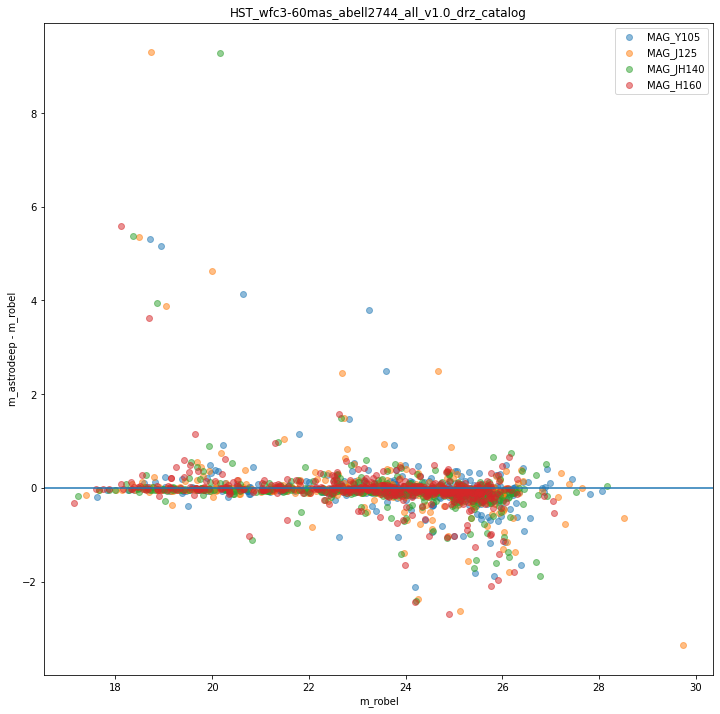

In [117]:
coords = []
for filt, ad_filt in zip(filter_list, ad_filter_list):
    cat = Table.read("hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz_catalog.csv".format(filt), format='ascii.csv')
    
    ad_values = []
    cat_values = []
    for row in cat:
        ra, dec = [float(i) for i in row['sky_centroid'].split(',')]
        mag = row['ab_mag']

        coord_delta = ((astro_deep_cat['RA'] - ra)**2 + (astro_deep_cat['DEC'] - dec)**2)
        idx = coord_delta.argmin()
        
        if coord_delta[idx] > 1e-8:
            continue
        
        ad_mag = astro_deep_cat[idx][ad_filt]

        if ad_mag < 99 and  -10 < (ad_mag - mag) < 10:
            ad_values.append(ad_mag - mag)
            cat_values.append(mag)
            
    plt.scatter(cat_values, ad_values, alpha=0.5, label=ad_filt)
    print("Mean[{}]:".format(ad_filt), np.array(ad_values).mean())
            
plt.axhline(0)
plt.legend()
plt.title("HST_wfc3-60mas_abell2744_all_v1.0_drz_catalog")
plt.xlabel("m_robel")
plt.ylabel("m_astrodeep - m_robel");

#plt.savefig('HST_wfc3-60mas_abell2744_all_v1.0_drz_catalog.png', dpi=500)